In [128]:
import numpy as np

from collections import Counter
from math import exp, log

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve

from matplotlib import pyplot as plt

from os import listdir

In [120]:
class Bayes(BaseEstimator):
	def __init__(self, k=2, lambdas=[1, 1], alpha=1, n=1):
		self.k = k
		self.lambdas = lambdas
		self.alpha = alpha
		self.n = n

		self.x_count = set()
		self.c_count = Counter()
		self.p = []

	
	def fit(self, x_train, y_train):
		data = [Counter() for _ in range(self.k)]
		for xs, c in zip(x_train, y_train):
			for x in set(xs):
				self.x_count.add(x)
				data[c][x] += 1
			self.c_count[c] += 1 
		
		self.p = [{x: (data[c][x] + self.alpha) / (self.c_count[c] + self.alpha * 2) for x in self.x_count} for c in range(self.k)]
		return self


	def calc_prob_of_xs_on_cond_of_c(self, xs, c):
		if self.c_count[c] == 0:
			return 0
		res = log(self.c_count[c] / sum(self.c_count.values()))
		for x in self.p[c]:
			if x in xs:
				res += log(self.p[c][x])
			else:
				res += log(1 - self.p[c][x])
		return res * self.lambdas[c]


	def predict_one(self, xs):
		xs = set(xs)
		denum = sum([self.calc_prob_of_xs_on_cond_of_c(xs, c) for c in range(self.k)])
		res = []
		for c in range(self.k):
			num = self.calc_prob_of_xs_on_cond_of_c(xs, c)
			res.append(num / denum)
		return res


	def predict(self, xs_test, y_score=False):
		predictions = list(map(self.predict_one, xs_test))
		if y_score:
			for c in predictions:
				c[0] /= sum(c)
				c[1] /= sum(c)
			return [1 - c[1] for c in predictions]
		return [c.index(min(c)) for c in predictions]

In [82]:
x = []
y = []

for i in range(1, 10 + 1):
    dir = 'part' + str(i)
    for file_name in os.listdir(dir):
        y.append(1 if 'spmsg' in file_name else 0)
        with open(dir + '/' + file_name) as f:
            subject = f.readline().split()[1:]
            f.readline()
            text = f.readline().split()
        x.append(subject + text)

f'Accuracy on train: {accuracy_score(Bayes().fit(x, y).predict(x), y)}'

'Accuracy on train: 0.9394495412844037'

In [100]:
def ngrams(text, n):
    return [' '.join(map(str, text[i:i+n])) for i in range(len(text) - n + 1)]

x_ngram = [ngrams(m, 2) for m in x]

In [140]:
def accuracy_wo_fp(true, predicted):
    assert(len(true) == len(predicted))
    num = 0
    fp = 0
    for t, p in zip(true, predicted):
        num += t == p
        fp += t == 0 and p != t
    if fp > 0:
        return -fp
    return num / len(true)

accuracy_wo_fp_score = make_scorer(accuracy_wo_fp, greater_is_better=True)

In [102]:
def cv(x):
    param_grid = {'alpha':   [1, 1e-1, 1e-2, 1e-4, 1e-6]
                 ,'lambdas': [(1, l) for l in [0.5, 1, 2, 5]]}
    clf = GridSearchCV(Bayes(), param_grid, cv=7, n_jobs=-1, scoring=accuracy_wo_fp_score)
    clf.fit(x, y)
    print(f'Accuracy without false positive errors on test: {clf.best_score_}')
    print(f'Best parameters: {clf.best_params_}')
    return clf

In [87]:
%%time
cv(x)

Accuracy without false positive errors on test: 0.6922899680964197
Best parameters: {'alpha': 1e-06, 'lambdas': (1, 1)}
Wall time: 6min 34s


GridSearchCV(cv=7, error_score=nan,
             estimator=Bayes(alpha=1, k=2, lambdas=[1, 1], n=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.0001, 1e-06],
                         'lambdas': [(1, 0.5), (1, 1), (1, 2), (1, 5)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_wo_fp), verbose=0)

In [103]:
%%time
cv(x_ngram)

Accuracy without false positive errors on test: 0.6908365827720667
Best parameters: {'alpha': 1e-06, 'lambdas': (1, 2)}
Wall time: 22min 17s


GridSearchCV(cv=7, error_score=nan,
             estimator=Bayes(alpha=1, k=2, lambdas=[1, 1], n=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.0001, 1e-06],
                         'lambdas': [(1, 0.5), (1, 1), (1, 2), (1, 5)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy_wo_fp), verbose=0)

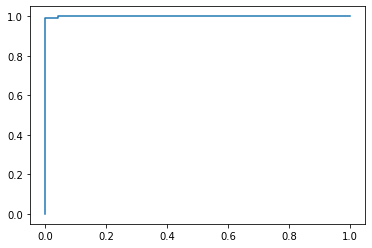

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

y_scores = Bayes(alpha=1e-6).fit(x_train, y_train).predict(x_test, y_score=True)

fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr);

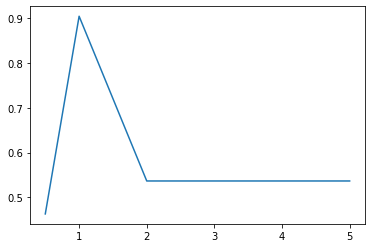

In [147]:
lambdas = [l for l in [0.5, 1, 2, 5]]
scores = [accuracy_score(Bayes(lambdas=(1, l)).fit(x_train, y_train).predit(x_test), y_test) for l in lambdas]
plt.plot(lambdas, scores);